# MagGeo v1.0 - Parallel Mode 

**Authors** | Fernando Benitez-Paez, Urška Demšar, Jed Long

**Contact**  | [Fernando.Benitez@st-andrews.ac.uk](mailto:Fernando.Benitez@st-andrews.ac.uk), [ud2@st-andrews.ac.uk](mailto:ud2@st-andrews.ac.uk), <jed.long@uwo.ca>

**nbviewer URL** | https://nbviewer.jupyter.org/github/MagGeo/MagGeo/blob/master/MagGeo_Parallel.ipynb

**Keywords** | Bird migration, data fusion, Earth’s magnetic field, Swarm, GPS tracking

## Overview

This Notebook will guide you through the required steps to annotate your GPS track with the earth magnetic field from Swarm Mission from European Spatial Agency, using the sequential Mode. If you need more information about Swarm mission go to the Main document, then concept requirements. This script will use a sequential loop to run an annotation process for each GPS Point (row) from your data.

Each cell is proper described to present the process established. you can go through the cell you will also find inner comments `##` to describe any particular step that might be unclear. The process has several cells with commands only required to validated some intermediary results and help you to understand how the data is being manipulated. 

**MagGeo** is available in parallel mode in order to process a considerable big dataset or gps tracks with millions of points than need to be annotated with the magnetic values. Taking the full advantage of your CPU capacity, the parallel mode will use the `multiprocessing` module from python(check the minimum requirements for **MagGeo**).

## Initial considerations

For parallel processing, there are some considerations to make:

1. Linux and Windows environments have some differences. In windows we need to separate the functions and store them separately, then import them into a `main` function. 
3. Defining what part of the process is <strong>CPU bound</strong> and what part is <strong>I/O bound</strong>: Identify what parts of the program are I/O bound (writing or reading from the disk or network) and what part par CPU bound ( Processing capacity). To take advantage of our CPU capacity we need to identify the process where the CPU is actually doing the main Tasks. Those are the functions and the processes we will parallelize. 

<div class="alert alert-info" role="alert">    
🔎 <strong>MagGeo can be divided in two parts: </strong>. 
<br>
    
The initial part is about to downloading the data and getting the residuals from the CHAOS model, this part is where the data is collected based on the GPS track date and times values. The second part is the interpolation <strong>ST-IDW</strong> and the annotation process where <strong>MagGeo</strong> is actually returning a new table or pandas dataframe with the magnetic values for each GPS date and time.

The initial part where MagGeo is getting the data is mostly *I/O bound*, as we have to download the data from Swarm Client and then compute the residuals to calculate the geomagnetic values at the ground level. Perhaps we might want to parallelize also this section, although due to this task is mainly getting the data from a external server it does not make too much sense dedicate several cores of CPU capacity for the same broadband capacity.

Instead,  we are going to store the <code>TotalSwarmData_A</code>,<code>TotalSwarmData_B</code> and <code>TotalSwarmData_C</code> pandas dataframes into csv files to be manipulated into a set of individuals functions. <strong>The parallel processing requires working with no intermediary results along the functions, so we need to guarantee that all the functions will have the parameters they need once they are invocated.</strong>
</div>

## Importing the requeried libraries

In [1]:
from viresclient import SwarmRequest
from viresclient import ClientConfig
import datetime as dt
import sys,os
from pathlib import Path
import pandas as pd
import numpy as np
import datetime, time
from datetime import timedelta
import math
import pathlib
from datetime import datetime
import time
import calendar
import datetime

import multiprocessing
import sklearn
from multiprocessing import Pool

## Reading the GPS track

The following steps will load the GPS track from a csv file, and set some requirements before download the data from Swarm.
Importing the GPS track. You can note that there is a folder to store the CSV file. Using `os.getcwd()` you can validate where the file is located.

In [2]:
gpsfilename="BirdGPSTrajectory.csv"
def getGPSData():
    nfp = pd.read_csv(r"./data/BirdGPSTrajectory.csv", parse_dates=[0], encoding='utf-8', dayfirst=True)
    gpsData = pd.DataFrame({'gpsLat':nfp['location-lat'], 'gpsLong': nfp['location-long'], 'gpsDateTime':nfp['timestamp']})
    return gpsData

In [3]:
# Calling the previous function to get the track as Dataframe.
GPSData = getGPSData()
GPSData.head()

,gpsLat,gpsLong,gpsDateTime
0,70.854717,68.307333,2014-09-08 05:54:00
1,70.830300,67.975050,2014-09-08 06:10:00
2,70.761717,67.752417,2014-09-08 06:26:00
3,70.686517,67.561983,2014-09-08 06:42:00
4,70.685450,67.548317,2014-09-08 07:14:00


## Date and time formatting 

Setting the date and time attributes for the requerided format and computing the epoch column. Values like Maximum and Minimun Date and time are also calculated.

In [4]:
#1 Convert the gpsDateTime to datetime python object
GPSData['gpsDateTime'] = pd.to_datetime(GPSData['gpsDateTime'], format='%d/%m/%Y %H:%M')
GPSData['gpsDateTime'] = GPSData['gpsDateTime'].map(lambda x: x.replace(second=0))
GPSData['gpsLat'] = GPSData['gpsLat'].astype(float)
#2 Adding new column epoch, will be usefuel to compare the date&time o each gps point againts the gathered swmarm data points
GPSData['epoch'] = GPSData['gpsDateTime'].astype('int64')//1e9
GPSData['epoch'] = GPSData['epoch'].astype(int)
#3 Computing Date and Time columns
GPSData['dates'] = GPSData['gpsDateTime'].dt.date
GPSData['times'] = GPSData['gpsDateTime'].dt.time
#4 Maximum and Minimum values
MinDateTime = min(GPSData['gpsDateTime'])
MaxDateTime = max(GPSData['gpsDateTime'])
dt_object1 = MinDateTime.to_pydatetime()
dt_object2 = MaxDateTime.to_pydatetime()
startDate = MinDateTime.date()
endDate = MaxDateTime.date()
MinTime=MinDateTime.time()
MaxTime=MaxDateTime.time()

## Validating the proper amount of Swarm measures

The annotation process apply an interpolation process which require for each GPS point time a set of Swarm points in the range of at least 4 hours before and 4 hours after each GPS Point time. To guarantee that all the GPS points have the enough amount of satellites measures.

**1**. The following loop is identifiying the time and validating if the time is less than 4:00 hours and more than 20:00 hours to bring one extra day of data. The result of this validation is written in a empty python list which will be later validated to get the unique dates avoing to download data for the same day and reducing the the downloand time process.

In [6]:
datestimeslist = []
for index, row in GPSData.iterrows():
    datetimerow  = row['gpsDateTime']
    daterow = row['dates']
    hourrow = row['times']
    hourrow = hourrow.strftime('%H:%M:%S')
    if hourrow < '04:00:00':
        date_bfr = daterow - (timedelta(days=1))
        datestimeslist.append(daterow)
        datestimeslist.append(date_bfr)
    if hourrow > '20:00:00':
        Date_aft = daterow + (timedelta(days=1))
        datestimeslist.append(daterow)
        datestimeslist.append(Date_aft)  
    else:
        datestimeslist.append(daterow)

**2.** Getting a list of unique dates, to being used to download the Swarm Data

In [7]:
def uniquelistdates(list): 
    x = np.array(list) 
    uniquelist = np.unique(x)
    return uniquelist

uniquelist_dates = uniquelistdates(datestimeslist)
uniquelist_dates

array([datetime.date(2014, 8, 18), datetime.date(2014, 8, 19),
       datetime.date(2014, 8, 25), datetime.date(2014, 8, 26),
       datetime.date(2014, 8, 27), datetime.date(2014, 8, 28),
       datetime.date(2014, 8, 29), datetime.date(2014, 8, 30),
       datetime.date(2014, 8, 31), datetime.date(2014, 9, 3),
       datetime.date(2014, 9, 5), datetime.date(2014, 9, 6),
       datetime.date(2014, 9, 8), datetime.date(2014, 9, 13),
       datetime.date(2014, 9, 14), datetime.date(2014, 9, 15),
       datetime.date(2014, 9, 17), datetime.date(2014, 9, 18),
       datetime.date(2014, 9, 19), datetime.date(2014, 9, 20),
       datetime.date(2014, 9, 21), datetime.date(2014, 9, 22),
       datetime.date(2014, 9, 23), datetime.date(2014, 9, 24),
       datetime.date(2014, 9, 25), datetime.date(2014, 9, 26),
       datetime.date(2014, 9, 27), datetime.date(2014, 9, 29),
       datetime.date(2014, 9, 30), datetime.date(2014, 10, 1),
       datetime.date(2014, 10, 2), datetime.date(2014, 10, 

## Downloading the data from Swarm and computing them at the ground level

Once the date and time columns have been defined, and the unique dates were identified the script can start the download process. Usually the data from Swarm is requested using only one satellite, however **MagGeo** will use the magnetic measures from the three satellite of the Swarm Mission. The following function (<code>GetSwarmData_and_residual</code>) is  mainly divided in two parts. Get the data from Swarm including the residuals and then compute the magnetic field at the ground level using the residuals from the CHAOS model. 

<div class="alert alert-warning" role="alert">
  <strong>🔎 CHAOS: </strong>

is a comprehensive field model, containing the modelled contributions of the time-varying core, the static crustal field, the average time-varying magnetosphere. We show calculation of the residuals (adding this parameter <code>residuals=True</code>) which means: data - <code>CHAOS(Core+Static)</code> and  data - <code>CHAOS(Core+Static+Magnetosphere)</code>.
    
</div>

The **CHAOS** model is available on the server as model variables:

- CHAOS-Core: SH degree 1-20
- CHAOS-Static: SH degree 21-110
- CHAOS-MMA-Primary: Magnetosphere external field, SH degree 1-2
- CHAOS-MMA-Secondary: Magnetosphere internal induced field, SH degree 1-2

We will use the abbreviations:

- MCO: core model
- MLI: lithosphere model (i.e. static)
- MMA: magnetosphere model

<div class="alert alert-info" role="alert">
📘  This will compute the magnetic measures not at the height of the three satellites ( 450 km and 550 km above the sea level) and will approximate calculate the Swarm measures at the ground level, making the measures more precise to any GPS trajectory.
</div>

**1.** Defining `GetSwarmData_and_residuals`fucntion to get Swarm data and compute the magnetic values at the ground level.

In [8]:
%%time

import chaosmagpy as cp
from chaosmagpy import load_CHAOS_matfile
from chaosmagpy.data_utils import mjd2000


def GetSwarmData_and_residuals (startDateTime, endDateTime, mid_date):
    
    # 1. Starting the Swarm Request.
    #    `SwarmRequest` is an object provided by the VirES interface, we need time objects 
    #    to be used by `SwarmRequest.get_between()` in this case we will request every date one day per loop (i.e. around 15 orbits)
    #    of the scalar (`F`) measurements from Swarm Satellites. The data are then loaded as a `xarray` dataframe.
    #    donwsamples the data to 60 seconds, from the `MAGx_LR` product having default of 1 second.
    #    https://viresclient.readthedocs.io/en/latest/available_parameters.html
    
    requestA = SwarmRequest() 
    requestB = SwarmRequest()
    requestC = SwarmRequest()
    
    #2. Loading the matlab CHAOS model to compute the residuals and resting those values from the residuals from Swarm.
    model = load_CHAOS_matfile('C:\\foss4guk19-jupyter-master\\Project_StAndrews\\Parallel\\CHAOS-7.mat') 
    #For more information about the magnetic models go to: https://www.space.dtu.dk/english/research/scientific_data_and_models/magnetic_field_models
    
    #3. Getting the data for Satellite A. 
    requestA.set_collection("SW_OPER_MAGA_LR_1B")
    requestA.set_products(
        measurements=[
            'B_NEC', #The Magnetic values are in NEC system (North, East, Centre)

        ],

        models = [
            '"CHAOS_MCO_MLI" = "CHAOS-Core" + "CHAOS-Static"',
            '"CHAOS_MCO_MLI_MMA" = "CHAOS-Core" + "CHAOS-Static" + "CHAOS-MMA-Primary" + "CHAOS-MMA-Secondary"'
        ],
        residuals=True, #Brining the residuals.
        sampling_step="PT60S", #Get the data every 60 seconds. 
    )
    
    #4. Defining an array to store the data request for Satellite A, based on the starting Data and time.
    #   You can display dsA to get an idea of how the data is requested.
    dsA = requestA.get_between(
        start_time=startDateTime,
        end_time=endDateTime
    ).as_xarray()
    
    
    #5. Brining the residuals from CHAOS Model, the one was loaded in step No 2.
    
    thetaA = 90-dsA["Latitude"].values  # colatitude in degrees (colatitude = 90-latitude)
    phiA = dsA["Longitude"].values  # longitude in degrees
    time = mjd2000(mid_date.year, mid_date.month, mid_date.day)  * np.ones((thetaA.size,)) # The core field does not change over a day so pick a single time
    radius = 6371.2 * np.ones((thetaA.size,))
    # this is the Earth's average radius - 
    # if you need to add the heigth of your GPS trajectory, you need to put in the bird's height in km above the centre of the Earth
    # and parsing this values as one extra parameter of this fuction. 
   
    #6. The residuals from the model CHAOS are computed.  
    B_r_coreA, B_t_coreA, B_phi_coreA = model.synth_values_tdep(time,radius, thetaA, phiA)
    B_r_crustA, B_t_crustA, B_phi_crustA = model.synth_values_static(radius, thetaA, phiA)
    
    #7. Once the xarray is created, we can extracted the variables included using xarray.DataArray object e.g. dsA["Latitude"]).
    # The SwarmRequest inside in the dsA xarray has Timestamp as index. The vector measurements have 3 dimensions which are 
    # the three components (N, E, C). One dimension can be extracted like indexing into a numpy ndarray. The N (Northwards)
    # component is accessed as xarray["variable"][:, index]:
    
    B_r_swarmA, B_t_swarmA, B_phi_swarmA = -dsA["B_NEC_res_CHAOS_MCO_MLI_MMA"][:, 2], -dsA["B_NEC_res_CHAOS_MCO_MLI_MMA"][:, 0], dsA["B_NEC_res_CHAOS_MCO_MLI_MMA"][:, 1]
   
    #8. Once the residuals are computed and extracted for Swarm data stored temporaly in xarray. The Magnetic fiel on
    #   the ground is computed.
    B_r_groundA = B_r_coreA + B_r_crustA - B_r_swarmA #(-Z)
    B_t_groundA = B_t_coreA + B_t_crustA - B_t_swarmA #(-X)
    B_phi_groundA = B_phi_coreA + B_phi_crustA - B_phi_swarmA #(Y)
    
    #9. Due to Swarm data are in NEC (or XYZ) while the CHAOS model outputs the radial, theta and phi components which are Br = -Z, 
    #   Bt = -X and BP = Y
    C_groundA = -B_r_groundA   #Z
    N_groundA = -B_t_groundA   #X
    E_groundA = B_phi_groundA  #Z
    
    #10. To finish the transformation and extraction process, a final dataframe is created, setting clear names and including
    #    a epoch columns to be the dataframe index.
    
    SwarmDataA = pd.DataFrame({'Na':N_groundA,'Ea':E_groundA, 'Ca':C_groundA, 'Ta':N_groundA['Timestamp'], 'LatA':dsA['Latitude'], 'LongA':dsA['Longitude']})
    SwarmDataA['epoch'] = SwarmDataA['Ta'].astype('int64')//1e9
    SwarmDataA['epoch'] = SwarmDataA['epoch'].astype(int)
    SwarmDataA.set_index("epoch", inplace=True)
    
    #11. The same process will take place for the satellites Bravo and Charlie.
    
    ######Request for Sat B #########
    requestB.set_collection("SW_OPER_MAGB_LR_1B")
    requestB.set_products(
        measurements=[
            'B_NEC',

        ],
        models = [
            '"CHAOS_MCO_MLI" = "CHAOS-Core" + "CHAOS-Static"',
            '"CHAOS_MCO_MLI_MMA" = "CHAOS-Core" + "CHAOS-Static" + "CHAOS-MMA-Primary" + "CHAOS-MMA-Secondary"'
        ],
        residuals=True, 
        sampling_step="PT60S",
    )

    dsB = requestB.get_between(
        start_time= startDateTime,
        end_time= endDateTime
    ).as_xarray()
    
    # Getting the residuals for SatB...
    thetaB = 90-dsB["Latitude"].values  # colatitude in degrees (colatitude = 90-latitude)
    phiB = dsB["Longitude"].values  # longitude in degrees
    time = mjd2000(mid_date.year, mid_date.month, mid_date.day)  * np.ones((thetaB.size,))
    radius = 6371.2 * np.ones((thetaB.size,))  
    B_r_coreB, B_t_coreB, B_phi_coreB = model.synth_values_tdep(time,radius, thetaB, phiB)
    B_r_crustB, B_t_crustB, B_phi_crustB = model.synth_values_static(radius, thetaB, phiB)
    
    B_r_swarmB, B_t_swarmB, B_phi_swarmB = -dsB["B_NEC_res_CHAOS_MCO_MLI_MMA"][:, 2], -dsB["B_NEC_res_CHAOS_MCO_MLI_MMA"][:, 0], dsB["B_NEC_res_CHAOS_MCO_MLI_MMA"][:, 1]


    B_r_groundB = B_r_coreB + B_r_crustB - B_r_swarmB #(-Z)
    B_t_groundB = B_t_coreB + B_t_crustB - B_t_swarmB #(-X)
    B_phi_groundB = B_phi_coreB + B_phi_crustB - B_phi_swarmB #(Y)
    
    C_groundB = -B_r_groundB   #Z
    N_groundB = -B_t_groundB   #X
    E_groundB = B_phi_groundB  #Y
    
    SwarmDataB = pd.DataFrame({'Nb':N_groundB,'Eb':E_groundB, 'Cb':C_groundB, 'Tb':N_groundB['Timestamp'], 'LatB':dsB['Latitude'], 'LongB':dsB['Longitude']})
    SwarmDataB['epoch'] = SwarmDataB['Tb'].astype('int64')//1e9
    SwarmDataB['epoch'] = SwarmDataB['epoch'].astype(int)
    SwarmDataB.set_index("epoch", inplace=True)
  
    ######Request for Sat C #########
    requestC.set_collection("SW_OPER_MAGC_LR_1B")
    requestC.set_products(
        measurements=[
            'B_NEC',

        ],
        models = [
            '"CHAOS_MCO_MLI" = "CHAOS-Core" + "CHAOS-Static"',
            '"CHAOS_MCO_MLI_MMA" = "CHAOS-Core" + "CHAOS-Static" + "CHAOS-MMA-Primary" + "CHAOS-MMA-Secondary"'
        ],
        residuals=True,
        sampling_step="PT60S",
    )

    dsC = requestC.get_between(
        start_time=startDateTime,
        end_time=endDateTime
    ).as_xarray()
    
    #Getting the residuals for SatC...
    thetaC = 90-dsC["Latitude"].values  # colatitude in degrees (colatitude = 90-latitude)
    phiC = dsC["Longitude"].values  # longitude in degrees
    time = mjd2000(mid_date.year, mid_date.month, mid_date.day)  * np.ones((thetaC.size,))
    radius = 6371.2 * np.ones((thetaC.size,)) 

    B_r_coreC, B_t_coreC, B_phi_coreC = model.synth_values_tdep(time,radius, thetaC, phiC)
    B_r_crustC, B_t_crustC, B_phi_crustC = model.synth_values_static(radius, thetaC, phiC)
    
    B_r_swarmC, B_t_swarmC, B_phi_swarmC = -dsC["B_NEC_res_CHAOS_MCO_MLI_MMA"][:, 2], -dsC["B_NEC_res_CHAOS_MCO_MLI_MMA"][:, 0], dsC["B_NEC_res_CHAOS_MCO_MLI_MMA"][:, 1]

    B_r_groundC = B_r_coreC+ B_r_crustC - B_r_swarmC #(-Z)
    B_t_groundC = B_t_coreC + B_t_crustC - B_t_swarmC #(-X)
    B_phi_groundC = B_phi_coreC + B_phi_crustC - B_phi_swarmC #(Y)
    
    C_groundC = -B_r_groundC   #Z
    N_groundC = -B_t_groundC   #X
    E_groundC = B_phi_groundC  #Y
    
    SwarmDataC = pd.DataFrame({'Nc':N_groundC,'Ec':E_groundC, 'Cc':C_groundC, 'Tc':N_groundC['Timestamp'], 'LatC':dsC['Latitude'], 'LongC':dsC['Longitude']})
    SwarmDataC['epoch'] = SwarmDataC['Tc'].astype('int64')//1e9
    SwarmDataC['epoch'] = SwarmDataC['epoch'].astype(int)
    SwarmDataC.set_index("epoch", inplace=True)
    
    return SwarmDataA,SwarmDataB,SwarmDataC

Wall time: 1.32 s


**2.** Running the previous function, using a loop to going through every date in the unique date list. The **Vires client API**, requires a token. You can visit https://vires.services/ to get your own token. We highly recommend to use your own token to run the script to annotate your own GPS tracks. As we mentioned in the previous function definition the `SwarmRequest()` object have the `get_between` parameter which require a datetime variables. As the unique list is just a date python variable, we set a range of **24 hours to download the data** for one entire day at the every iteration. 

<div class="alert alert-warning" role="alert">
  <strong>🔈  Note: 🔈 </strong>
    <br> If you are aware that rather to download each day in the unique list we might set a minimum and maximum dates for the GPS track dates and thus get the entire data at once. Unfortunately due to the calculations required to compute the residual from the <strong>local CHAOS model</strong>, the number of days is limited to 10 days, including more days will raise a error into the chaosmagpy package. Likewise the amount of processing and downloading time is certainly very similar to get each date into a loop iteration. Therefore we have choose the most secure option.
</div>

<div class="alert alert-info" role="alert">
📘 <strong>Be aware:</strong> Due to the amount of dates the GPS track has (40 days) to get and compute the residuals, the time to process the sample data will take approximately 20 minutes.</div>

In [ ]:
%%time

hours_t_day = 24
hours_added = datetime.timedelta(hours = hours_t_day)

listdfa = []
listdfb = []
listdfc = []

cc = ClientConfig()
cc.set_site_config("https://vires.services/ows", token="rp-foC8gz-VTFz7He6SMPnQtKEpasEaB")
cc.default_url = "https://vires.services/ows"
cc.save()

for d in uniquelist_dates:
    print("Process for:",d,":" )
    startdate = datetime.datetime.combine(d, datetime.datetime.min.time())
    enddate = startdate + hours_added
    mid_date = d
    SwarmDataA,SwarmDataB,SwarmDataC = GetSwarmData_and_residuals(startdate, enddate,mid_date)
    listdfa.append(SwarmDataA)
    listdfb.append(SwarmDataB)
    listdfc.append(SwarmDataC)

**3.**  As you might noted in the previous cell we append the results from each iteration into a empty python list. In here we join a sequence of arrays along the 0 axis (by applying the `concant` function ), to get a pandas dataframe that contains the data for each Swarm satellite for all the unique dates we identified in the GPS track `datetime` column.

In [10]:
TotalSwarm_A = pd.concat(listdfa, join='outer', axis=0)
TotalSwarm_B = pd.concat(listdfb, join='outer', axis=0)
TotalSwarm_C = pd.concat(listdfc, join='outer', axis=0)
TotalSwarm_A

,Na,Ea,Ca,Ta,LatA,LongA
epoch,,,,,,
1408320000,8488.049419,3678.042652,56977.116484,2014-08-18 00:00:00,66.843847,-134.672531
1408320060,6299.698812,2809.512836,57193.881921,2014-08-18 00:01:00,70.654918,-133.562740
1408320120,4255.902625,1903.310746,57385.441493,2014-08-18 00:02:00,74.451293,-131.817227
1408320180,2557.202078,950.302393,57136.797202,2014-08-18 00:03:00,78.218581,-128.828006
1408320240,948.024938,29.660529,56837.439504,2014-08-18 00:04:00,81.915833,-122.893911
...,...,...,...,...,...,...
1414194900,17270.821182,380.548962,-60386.025805,2014-10-24 23:55:00,-41.301711,126.631396
1414194960,20199.426726,773.035388,-57734.412499,2014-10-24 23:56:00,-37.480910,126.676727
1414195020,22835.551180,1099.487363,-54725.456681,2014-10-24 23:57:00,-33.658749,126.693239


## Writting the requested data in Disk, to be used into the requeried functions
In Parallel mode we can not use a temporary results, therefore we need to store in disk the previous pandas dataframes in csv files.

In [13]:
####Removing all previous files(.csv) to guarantee the script will use only the recent ones.
SwarmDir= os.getcwd()
filelist = [ f for f in os.listdir(SwarmDir) if f.endswith(".csv") ]
for f in filelist:
    os.remove(os.path.join(SwarmDir, f))


TotalSwarm_A.to_csv ('SwarmDataA.csv', header=True)
TotalSwarm_B.to_csv ('SwarmDataB.csv', header=True)
TotalSwarm_C.to_csv ('SwarmDataC.csv', header=True)

## Setting number of processes, and splitting the dataframe (GPSData) in chunks

We can set the number or processess we need to dedicate for the multiprocessing mode, of course that also depends on the number of cores the machine you are using to run **MagGeo**. You can use `multiprocessing.cpu_count()` to set the number of processes as the the number of cores your machine has. Beside that we will also to split the GPS track into chucks to dedicate each core for each chuck.

In [ ]:
NumCores = multiprocessing.cpu_count()
df_chunks = np.array_split(GPSData,NumCores)
df_chunks

## Interpolation (ST-IDW) and Annotation Process

Once we have downloaded the data we need for each point in the GPS Track and considering we have gathered the available data from the three satellites for one day ( *24 hours, every 60 seconds around 1440 Swarm measures per satellite*). Now we need to `filter` in space and time the available points to compute the magnetic values for each GPS point in its particular date and time. Therefore, before running the interpolation process we set **four** functions that will require the *latitude* and *longitude* and the *epoch* time of each GPS point to filter the Swarm points into what we called **Space-Time Cylinder**. The following picture can provide a better explanation about how the points inside the space-time cylinder are included or excluded. **Figure I**, shows the idea behid the interpolation process for each GPS point, downloading and processing the avaliable Swarm messuares by the three satellites. **Figure II**, illustrate the geometric components behing the space-time cylinder where the points are filtered and included in the interpolation process. Figure B, will help you to understand how the following functions compute the required parameters **Figure III** shows how the R of the Space-Time cylinder is based on the GPS point latitude. For more information about the time-space windows please read the full paper where we explain the details of it.

<img src="./images/AnnotateServiceJupiter.jpg" >

## Running the process in parallel mode

Although the next cell seems to run a small `main` function.  What is happening is a call for several functions running at same time for several cores. Initially we set a pool of processes. Using the `pool` class we will distribute the assigned function among the data chucks we created. Every data chunk will be like a subset of the entire GPS track. So we need to iterate among data chunk. And inside every data chunk we need to identify the `datetime`, `epoch`, `latitude` and `longitude` of each row to run the interpolation & annotation process using the Swarm data we have filtered and stored in the previous steps.

The function in charge to distribute the required function (`row_handler`) among the data chunks is the map function from the `pool` class. 

`row_handler.py` is an interows iteration to get the required parameter for the `SwarmMagAnnotation` function. 

<div class="alert alert-info" role="alert">
<strong>📘 Auxiliary Functions:</strong>
 
<ol>
  <li><strong>SwarmMagAnnotation</strong> function: This is the main function in charce to read the Swarm Data already filtered, and then import  <code>DfTime_func</code>,  <code>distance_to_GPS</code>, <code>Kradius</code> , <code>DistJ</code> functions to compute the spatial-time cylinder and the annotation process. The return of this function is a row (dictionary) that will be appended into a python list where all the results from the different cores. The python list from every process is concatenated into a pandas dataframe in the <code>main</code> function having there the whole chain of the parallel process.</li>
  <li><strong>distance_to_GPS</strong> function: Is the function in charge to calculate the distance between each GPS Point and the Swarm Point.</li>
  <li><strong>Kradius</strong> function: Is the function in charge to compute the R (radius) value in the cylinder. The R value will be considered based on the latitude of each GPS Point.</li>
    <li><strong>DistJ</strong> function: This function will calculate the <code>d</code> value as the hypotenuse created in the triangle created amount the locations of the GPS point, the location of the Swarm points and the radius value.</li>
  <li><strong>DfTime_func</strong> function: This is a time function to selected the points in the range of a the DeltaTime - <code>DT</code> window. The Delta time window has been set as 4 hours for each satellite trajectory.</li>
</ol> 

</div>

<div class="alert alert-warning" role="alert">
    
There is one additional parameter into the parallel process. <code>DeltaTime (DT)</code> is the parameter we can setup to define how many Swarm we will include into the time window of the space-time cylinder. The default configuration is <code>DT = 14400</code> or 4 hours which we estimated to be the period where we can have the three satellites going along for the same point on earth.
</div>


In [15]:
%%time
from functools import partial
import row_handler

if __name__ == '__main__':
    with multiprocessing.Pool(NumCores) as pool:
        GeoMagParallelResult = pd.concat(pool.map(partial(row_handler.row_handler, DT=14400), df_chunks), ignore_index=True)

Wall time: 12.2 s


With the Parallel mode the Annotation process takes about 12 seconds to complete ( We had tested the parallel process in a  windows server machine with 12 cores, see the image bellow). With the same GPS track in the sequetial mode the process is complete in about 2 minutes. In the image bellow you can see how the machine create several python processes and all cores (full CPU capacity) is taken.

<div class="alert alert-warning" role="alert">
<strong>🔈 Multiprocessing:</strong>

is even  more powerfull when you have to process a big amount of data (e.g. 2 millons of points). Although here is making a notable improvement if you have to process a big dataset the parallelization makes even more sense.

</div>

<img src="./images/CoresWorking.png" style="zoom: 100%;" >


In [16]:
GeoMagParallelResult.head(10)

,Latitude,Longitude,DateTime,Fgps,N,E,C,H,D,I,TotalPoints,MinDist,AvDist
0,70.854717,68.307333,2014-09-08 05:54:00,58263.516606,6533.771524,3145.053928,57810.516628,7251.312608,0.448619,1.446016,21,327.950987,626.701218
1,70.830300,67.975050,2014-09-08 06:10:00,58261.123705,6538.091436,3149.741775,57807.361318,7257.238653,0.448943,1.445908,21,340.038476,628.953831
2,70.761717,67.752417,2014-09-08 06:26:00,58058.984855,6682.091934,3212.055102,57583.661501,7414.017169,0.448086,1.442749,26,348.223318,656.804069
3,70.686517,67.561983,2014-09-08 06:42:00,58056.861413,6699.935204,3220.395629,57578.981212,7433.712380,0.448057,1.442402,26,355.472899,657.901776
4,70.685450,67.548317,2014-09-08 07:14:00,58045.681746,6704.933680,3235.486162,57566.280608,7444.763687,0.449593,1.442185,26,355.980432,657.921513
5,70.685750,67.549433,2014-09-08 07:30:00,58025.343330,6715.628143,3249.373034,57543.743205,7460.434738,0.450646,1.441867,26,355.937927,657.916808
6,70.690333,67.530983,2014-09-08 07:46:00,57990.038391,6733.573966,3269.069234,57504.927793,7485.174147,0.451971,1.441358,26,356.593532,657.856468
7,70.692683,67.506233,2014-09-08 08:03:00,57936.413695,6762.515584,3296.360226,57445.891272,7523.138160,0.453554,1.440577,26,357.491672,657.831026
8,70.692533,67.506167,2014-09-08 08:34:00,57803.666217,6836.087914,3357.377373,57299.736015,7616.041018,0.456523,1.438655,26,357.494814,657.833213
9,70.692583,67.506383,2014-09-08 08:50:00,57718.201582,6883.306232,3391.968293,57205.816490,7673.679273,0.457856,1.437451,26,357.486638,657.832415


## Validating the results
To validate the results we plot the `Fgps`column. You will note that there is an significat outlier with Magnetic Intensity values with Zero.

In [17]:
## Creating a copy of the results and setting the Datetime Column as dataframe index.
ValidateDF = GeoMagParallelResult.copy()
ValidateDF.set_index("DateTime", inplace=True)

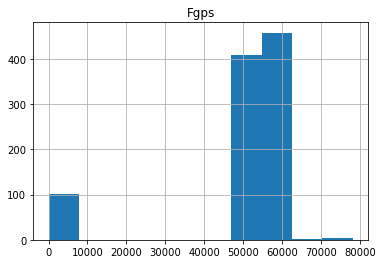

In [18]:
## Plotting the Fgps column.
import matplotlib.pyplot as plt
hist = ValidateDF.hist(column='Fgps')

Having Zero values means that there was no Swarm points into the ST-Cylinder for certains rows with specific date and time. The `DeltaTime` parameter have an important impact to determine how many points the ST-IDW process will consider. The following figure shows the difference to choose a `DeltaTime` parameter of 4 hours (14400 seconds) and 12 hours (43200 seconds).

<img src="./images/DetaTimeDiff_Jupyter.png" >

## Selecting rows with no Magnetic messures

Despite we include the magnetic measures from the three satellites of Swarm. There are cases or locations where there is no Swarm points for the defined **Space-Time Window**. To address this issue we can change the `DeltaTime` (DT) parameter to increase the "height" of our Space-Time cylinder. In order to reach more Swarm measures we will  set a ***new deltatime of 12 hours*** only for those points with issues to get the satellite data. But first we need to filter those points with no magnetic values and create another pandas dataframe to be used as a "new" GPS track and run the interpolation & annotation process again with the new DT.

**1**. Initially we set new dataframes for the set of point with the Column `TotalPoint` with Zero, and we create another pandas dataframe with the remaining rows to later on combine with the result from the latest annotation process.

In [19]:
ZeroValues = GeoMagParallelResult[GeoMagParallelResult.TotalPoints == 0]
NoZeroValues = GeoMagParallelResult[(GeoMagParallelResult[['TotalPoints']] != 0).all(axis=1)]
NoZeroValues.head(10)

,Latitude,Longitude,DateTime,Fgps,N,E,C,H,D,I,TotalPoints,MinDist,AvDist
0,70.854717,68.307333,2014-09-08 05:54:00,58263.516606,6533.771524,3145.053928,57810.516628,7251.312608,0.448619,1.446016,21,327.950987,626.701218
1,70.830300,67.975050,2014-09-08 06:10:00,58261.123705,6538.091436,3149.741775,57807.361318,7257.238653,0.448943,1.445908,21,340.038476,628.953831
2,70.761717,67.752417,2014-09-08 06:26:00,58058.984855,6682.091934,3212.055102,57583.661501,7414.017169,0.448086,1.442749,26,348.223318,656.804069
3,70.686517,67.561983,2014-09-08 06:42:00,58056.861413,6699.935204,3220.395629,57578.981212,7433.712380,0.448057,1.442402,26,355.472899,657.901776
4,70.685450,67.548317,2014-09-08 07:14:00,58045.681746,6704.933680,3235.486162,57566.280608,7444.763687,0.449593,1.442185,26,355.980432,657.921513
5,70.685750,67.549433,2014-09-08 07:30:00,58025.343330,6715.628143,3249.373034,57543.743205,7460.434738,0.450646,1.441867,26,355.937927,657.916808
6,70.690333,67.530983,2014-09-08 07:46:00,57990.038391,6733.573966,3269.069234,57504.927793,7485.174147,0.451971,1.441358,26,356.593532,657.856468
7,70.692683,67.506233,2014-09-08 08:03:00,57936.413695,6762.515584,3296.360226,57445.891272,7523.138160,0.453554,1.440577,26,357.491672,657.831026
8,70.692533,67.506167,2014-09-08 08:34:00,57803.666217,6836.087914,3357.377373,57299.736015,7616.041018,0.456523,1.438655,26,357.494814,657.833213
9,70.692583,67.506383,2014-09-08 08:50:00,57718.201582,6883.306232,3391.968293,57205.816490,7673.679273,0.457856,1.437451,26,357.486638,657.832415


**2**. We need to do some formatting, removing not necessary columns, and transforming the pandas dataframe as a "new" GPS track, but including only those rows where there was no magnetic measures.

In [ ]:
ZeroValues.drop(['Fgps','N','E','C','H','D','I','TotalPoints','MinDist','AvDist'], axis=1, inplace=True)
ZeroValues.rename(columns={"Latitude": "gpsLat", "Longitude": "gpsLong", "DateTime":"gpsDateTime"}, inplace=True)
ZeroValues['epoch'] = ZeroValues['gpsDateTime'].astype('int64')//1e9

In [21]:
ZeroValues

,gpsLat,gpsLong,gpsDateTime,epoch
71,57.427383,31.894067,2014-10-01 02:42:00,1.412131e+09
72,57.321483,31.669200,2014-10-01 02:59:00,1.412132e+09
73,57.195767,31.446667,2014-10-01 03:14:00,1.412133e+09
88,53.353933,19.858717,2014-10-01 14:38:00,1.412174e+09
89,53.324533,19.568867,2014-10-01 14:54:00,1.412175e+09
...,...,...,...,...
930,56.149062,18.176637,2014-10-24 02:00:00,1.414116e+09
931,56.153519,18.174781,2014-10-24 02:30:00,1.414118e+09
932,56.158215,18.171885,2014-10-24 03:00:00,1.414120e+09
963,55.874354,13.298577,2014-10-23 13:30:00,1.414071e+09


## Running the ST-IDW and annotation process for the problematic rows

**1**. Now we separated in two dataframes the rows with no magnetic values and the one that were correctly compute. We can use the `ZeroValues` dataframe to run one more time the **ST-IDW process** but including a wider time window. The DeltaTime for this subset of data will be `DT = 43200`corresponding to 12 hours of data. Before to run the annotation process, we need to define a new dataframe chunks based on the number of cores.

In [ ]:
df_chunks_z = np.array_split(ZeroValues,NumCores)
df_chunks_z

**2**. Running the Parallel process with the new DeltaTime parameter

In [23]:
%%time
from functools import partial
import row_handler

if __name__ == '__main__':
    with multiprocessing.Pool(NumCores) as pool:
        GeoMagParallelResult_Zero = pd.concat(pool.map(partial(row_handler.row_handler, DT=43200), df_chunks_z), ignore_index=True)

Wall time: 4.65 s


In [42]:
GeoMagParallelResult_Zero.head(10)

,Latitude,Longitude,DateTime,Fgps,N,E,C,H,D,I,TotalPoints,MinDist,AvDist
0,57.427383,31.894067,2014-10-01 02:42:00,52102.884319,15444.077385,2699.635046,49688.056902,15678.251039,0.173052,1.265150,50,173.642413,844.927569
1,57.321483,31.669200,2014-10-01 02:59:00,52061.839343,15474.859340,2665.622952,49637.267234,15702.764639,0.170581,1.264408,51,188.018658,854.398465
2,57.195767,31.446667,2014-10-01 03:14:00,52017.092826,15556.354382,2642.681862,49566.057105,15779.224603,0.168272,1.262593,50,203.258382,849.222223
3,53.353933,19.858717,2014-10-01 14:38:00,49794.857074,17829.665513,1529.071515,46468.190830,17895.111958,0.085551,1.203196,38,107.478811,701.623768
4,53.324533,19.568867,2014-10-01 14:54:00,49751.815612,17861.152223,1503.119436,46410.807254,17924.288739,0.083958,1.202235,36,99.748146,667.786960
5,53.259633,18.964567,2014-10-01 15:26:00,49741.632061,17884.554474,1512.914530,46390.556809,17948.431661,0.084392,1.201635,36,95.335092,662.784781
6,53.268217,18.664850,2014-10-01 15:42:00,49744.446092,17881.372127,1517.892231,46394.638171,17945.680984,0.084684,1.201716,36,94.869787,661.181614
7,53.795533,16.179567,2014-10-02 03:42:00,49921.108624,17673.468655,1542.744708,46662.463831,17740.675172,0.087071,1.207482,44,185.067407,818.002348
8,53.889767,16.161283,2014-10-02 04:14:00,49977.374339,17580.507713,1542.652066,46757.715074,17648.060144,0.087524,1.209891,43,177.811972,807.622829
9,54.208517,15.977883,2014-10-02 05:02:00,50091.596625,17362.673188,1512.425199,46961.880310,17428.420761,0.086889,1.215433,42,162.258561,798.198321


## Integrating the final result
To finish the process we join both dataframes into a final `MagDataFinal` dataframe, including the dataframe intially processed with the original delta time value and the dataframe that was processed uisng a wider delta time value to include a bigger range of points into the space and time cylinder and run the ST-IDW process.

We will concatenate the two dataframes with the same schema and with the correct magnetic values. The entire GPS track has been annotated with the magnetic components from Swarm and computed at the ground level. The final dataframe will include the following components:

<div class="alert alert-warning" role="alert">
    <strong>📘 The final dataframe will include the following components:</strong>
    <ul>
      <li><strong>Latitude</strong> from the GPS Track.</li>
      <li><strong>Longitude</strong> from the GPS Track.</li>
      <li><strong>Timestamp</strong> from the GPS Track.</li>
      <li><strong>Magnetic Field Intensity</strong>  mapped as Fgps in nanoTeslas (nT).</li>
      <li><strong>N (Northwards) component</strong> mapped as N in nanoTeslas (nT).</li>
      <li><strong>E (Eastwards) component</strong> mapped as E. in nanoteslas (nT).</li>
      <li><strong>C (Downwards or Center)</strong> component mapped as C in nanoTeslas (nT).</li>
      <li><strong>Horizontal component</strong> mapped as H in nanoTeslas (nT).</li>
      <li><strong>Magnetic Declination or dip angle</strong> mapped as D in degrees</li>
        <li><strong>Total Points</strong> as the amount of Swarm messuares included in the ST-IDW process from the trajectories requested in the three satellites.</li>
        <li><strong>Minimum Distance</strong> mapped as MinDist, representing the minimum distance amount the set of identified point inside the Space Time cylinder and each GPS point location.</li>
        <li><strong>Average Distance</strong> mapped as AvDist, representing the average distance amount the set of distances between the identified Swarm Point in the Space Time cylinder and the GPS Points location.</li>
    </ul>
</div> 

In [36]:
GeoMagResults= pd.concat([GeoMagParallelResult_Zero, NoZeroValues])
GeoMagResults.head()

,Latitude,Longitude,DateTime,Fgps,N,E,C,H,D,I,TotalPoints,MinDist,AvDist
0,57.427383,31.894067,2014-10-01 02:42:00,52102.884319,15444.077385,2699.635046,49688.056902,15678.251039,0.173052,1.265150,50,173.642413,844.927569
1,57.321483,31.669200,2014-10-01 02:59:00,52061.839343,15474.859340,2665.622952,49637.267234,15702.764639,0.170581,1.264408,51,188.018658,854.398465
2,57.195767,31.446667,2014-10-01 03:14:00,52017.092826,15556.354382,2642.681862,49566.057105,15779.224603,0.168272,1.262593,50,203.258382,849.222223
3,53.353933,19.858717,2014-10-01 14:38:00,49794.857074,17829.665513,1529.071515,46468.190830,17895.111958,0.085551,1.203196,38,107.478811,701.623768
4,53.324533,19.568867,2014-10-01 14:54:00,49751.815612,17861.152223,1503.119436,46410.807254,17924.288739,0.083958,1.202235,36,99.748146,667.786960


## Validating the final results for new outliers

Before mapping the final results, it would be useful to validate again we did not get any outlier and all the GPS Track rows have a proper Magnetic Values.

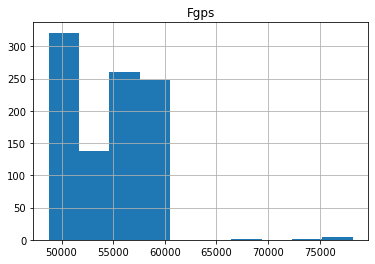

In [37]:
hist3 = GeoMagResults.hist(column='Fgps')

## Mapping the GPS Track using the annotated Magnetic Values (Optional)

Now we are going to plot the annotated GPS track stored into the MagDataFinal dataframe to see how the different magnetic components in a map to have a better prespective of the impact of the earth magnetic field.

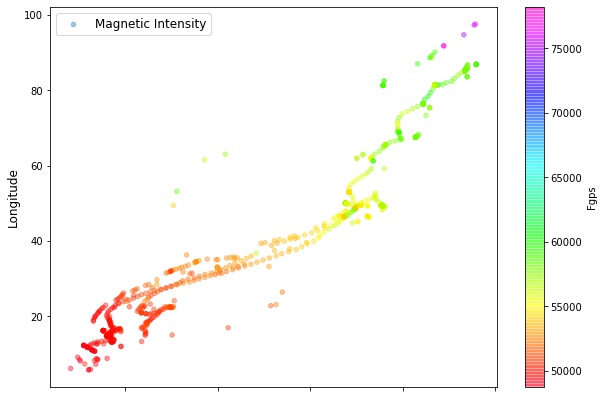

In [38]:
import matplotlib.pyplot as plt

GeoMagResults.plot(kind="scatter", x="Latitude", y="Longitude",
    label="Magnetic Intensity",
    c="Fgps", cmap=plt.get_cmap("gist_rainbow"),
    colorbar=True, alpha=0.4, figsize=(10,7)
    
)

plt.ylabel("Longitude", fontsize=12)
plt.xlabel("Latitude", fontsize=12)
plt.legend(fontsize=12)
plt.show()

In [39]:
import geopandas
import geoplot
gdf = geopandas.GeoDataFrame(GeoMagResults, geometry=geopandas.points_from_xy(MagDataFinal.Longitude, MagDataFinal.Latitude))
gdf.head()

,Latitude,Longitude,DateTime,Fgps,N,E,C,H,D,I,TotalPoints,MinDist,AvDist,geometry
0,57.427383,31.894067,2014-10-01 02:42:00,52102.884319,15444.077385,2699.635046,49688.056902,15678.251039,0.173052,1.265150,50,173.642413,844.927569,POINT (31.89407 57.42738)
1,57.321483,31.669200,2014-10-01 02:59:00,52061.839343,15474.859340,2665.622952,49637.267234,15702.764639,0.170581,1.264408,51,188.018658,854.398465,POINT (31.66920 57.32148)
2,57.195767,31.446667,2014-10-01 03:14:00,52017.092826,15556.354382,2642.681862,49566.057105,15779.224603,0.168272,1.262593,50,203.258382,849.222223,POINT (31.44667 57.19577)
3,53.353933,19.858717,2014-10-01 14:38:00,49794.857074,17829.665513,1529.071515,46468.190830,17895.111958,0.085551,1.203196,38,107.478811,701.623768,POINT (19.85872 53.35393)
4,53.324533,19.568867,2014-10-01 14:54:00,49751.815612,17861.152223,1503.119436,46410.807254,17924.288739,0.083958,1.202235,36,99.748146,667.786960,POINT (19.56887 53.32453)


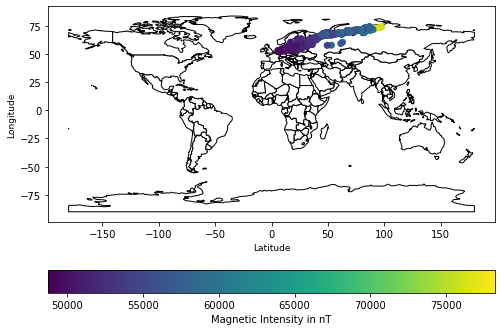

In [40]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
# We restrict to South America.
ax = world.plot(color='white', edgecolor='black', figsize = (8,6))

# We can now plot our ``GeoDataFrame``.
gdf.plot(ax=ax, column='Fgps', legend=True, 
         legend_kwds={'label': "Magnetic Intensity in nT",
                      'orientation': "horizontal"})
plt.ylabel("Longitude", fontsize=9)
plt.xlabel("Latitude", fontsize=9)

plt.show()

Text(567.7954545454544, 0.5, 'Longitude')

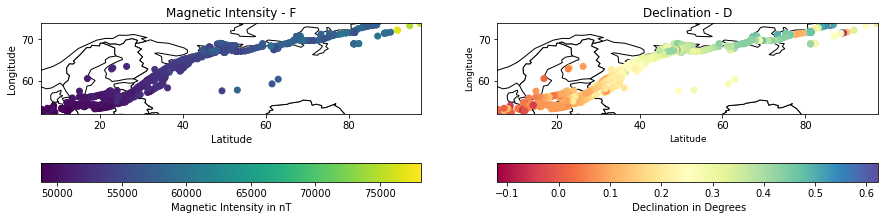

In [41]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (15,6))

ax1 = world.plot(ax=ax1, color='white', edgecolor='black')
xlim = ([gdf.total_bounds[0],  gdf.total_bounds[2]])
ylim = ([gdf.total_bounds[1],  gdf.total_bounds[3]])
ax1.set_xlim(xlim)
ax1.set_ylim(ylim)


gdf.plot(ax=ax1, column='Fgps', legend=True,
         legend_kwds={'label': "Magnetic Intensity in nT",
                      'orientation': "horizontal"})
plt.ylabel("Longitude", fontsize=9)
plt.xlabel("Latitude", fontsize=9)
ax1.set_title('Magnetic Intensity - F')
ax1.set_xlabel('Latitude')
ax1.set_ylabel('Longitude')


ax2 = world.plot( ax=ax2, color='white', edgecolor='black')
xlim = ([gdf.total_bounds[0],  gdf.total_bounds[2]])
ylim = ([gdf.total_bounds[1],  gdf.total_bounds[3]])
ax2.set_xlim(xlim)
ax2.set_ylim(ylim)


# We can now plot our ``GeoDataFrame``.
gdf.plot(ax=ax2, column='D', legend=True, cmap='Spectral', 
         legend_kwds={'label': " Declination in Degrees",
                      'orientation': "horizontal"})
ax2.set_title('Declination - D')
ax2.set_xlabel('Latitude')
ax2.set_ylabel('Longitude')

## Exporting the final results to a CSV file


In [35]:
#Exporting the CSV file
os.chdir(r"./results")
outputfile ="GeoMag_"+gpsfilename
export_csv = MagDataFinal.to_csv (outputfile, index = None, header=True)